a) Dataset Selection and Description
The Fashion MNIST dataset consists of 28x28 grayscale images of 10 categories (e.g., T-shirts, trousers).


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split #For train-validation split

# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Hyperparameter for normalization
normalization_factor = 255.0  

# Normalize data to [0, 1] range
X_train = X_train / normalization_factor
X_test = X_test / normalization_factor

# Flatten 28x28 images to 1D vectors (784 features)
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# Create Train-Validation Split
X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(
    X_train, y_train_onehot, test_size=0.1, random_state=42, stratify=y_train  # 10% for validation
)

print(f"Training set: {X_train.shape}, {y_train_onehot.shape}")
print(f"Validation set: {X_val.shape}, {y_val_onehot.shape}")
print(f"Test set: {X_test.shape}, {y_test_onehot.shape}")




Training set: (54000, 784), (54000, 10)
Validation set: (6000, 784), (6000, 10)
Test set: (10000, 784), (10000, 10)


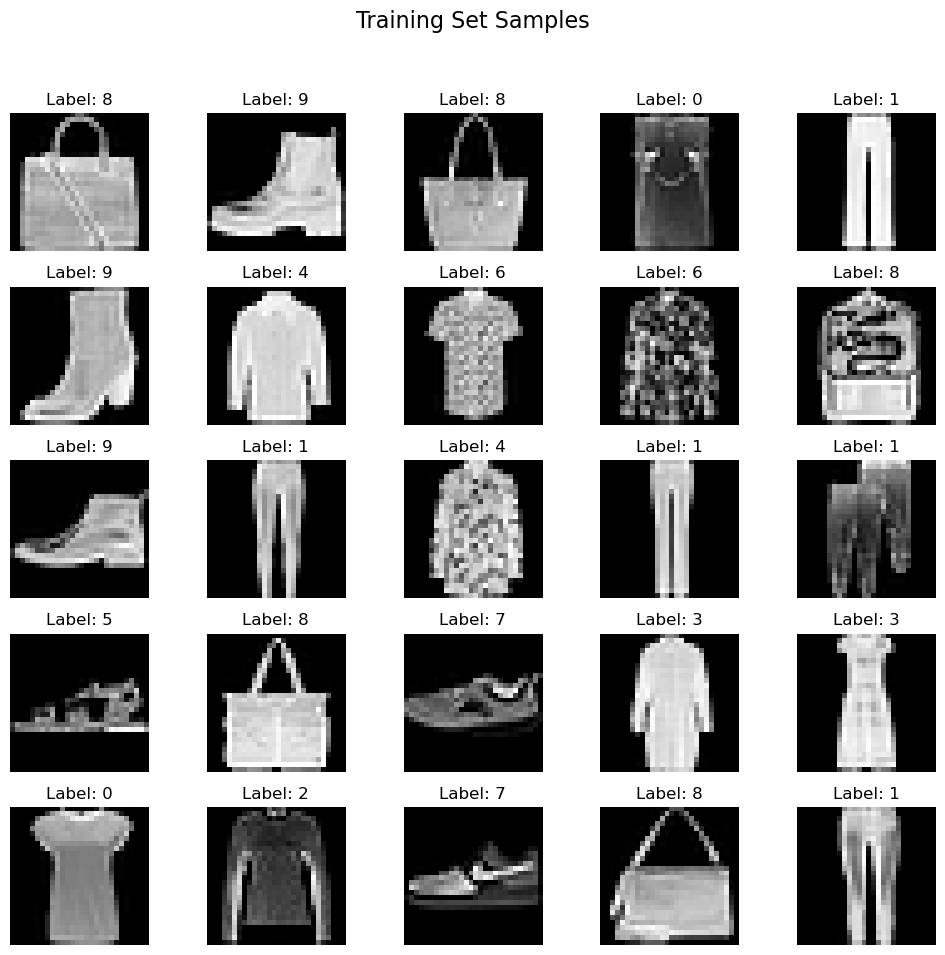

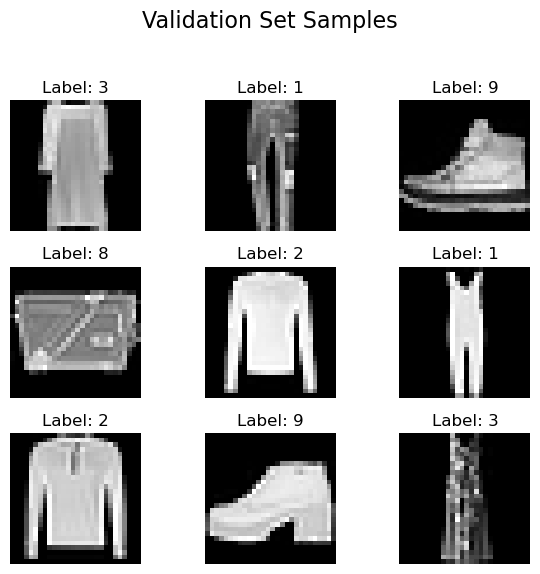

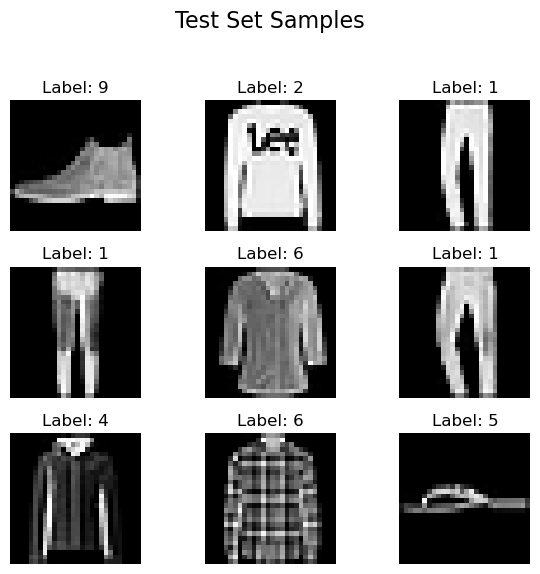

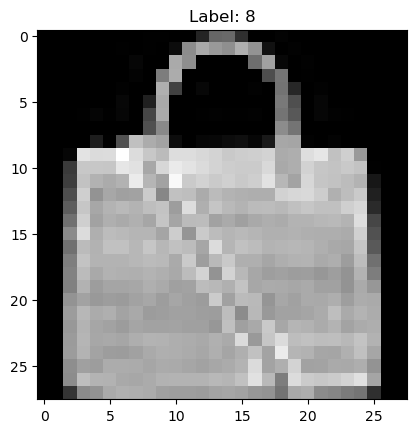

In [13]:
# Visualize sample images (customized)
def visualize_samples(images, labels, num_rows=4, num_cols=4, figure_title="Sample Images"):
    """Visualizes sample images in a grid."""
    num_images = num_rows * num_cols
    plt.figure(figsize=(2 * num_cols, 2 * num_rows))  # Adjust figure size
    plt.suptitle(figure_title, fontsize=16) # Add a title to the figure
    for i in range(min(num_images, len(images))): #Handle cases where there are less images than the grid size
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}") #Show the decoded label
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for the suptitle
    plt.show()

visualize_samples(X_train, y_train_onehot, num_rows=5, num_cols=5, figure_title="Training Set Samples")
visualize_samples(X_val, y_val_onehot, num_rows=3, num_cols=3, figure_title="Validation Set Samples") #Visualize validation samples as well
visualize_samples(X_test, y_test_onehot, num_rows=3, num_cols=3, figure_title="Test Set Samples") #Visualize test samples as well

# Example of plotting a single image
def visualize_single_image(image, label):
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.title(f"Label: {np.argmax(label)}")
    plt.show()

visualize_single_image(X_train[0], y_train_onehot[0])

b) Implement Sigmoid and ReLU Layers

In [14]:
class Sigmoid:
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, dout):
        return dout * self.output * (1 - self.output)


class ReLU:
    def forward(self, x):
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, dout):
        return dout * (self.output > 0)


c) Implement Softmax Layer



In [15]:
import numpy as np

def softmax(vector):
    """
    Compute the softmax of a vector or matrix.
    """
    # Subtracting max for numerical stability
    e = np.exp(vector - np.max(vector, axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

class Softmax:
    def forward(self, x):
        """
        Forward pass for the softmax layer.
        """
        self.output = softmax(x)  
        return self.output

    def backward(self, y_pred, y_true):
        """
        Backward pass for the softmax layer with cross-entropy loss.
        Args:
            y_pred: Predicted probabilities from the softmax function.
            y_true: True labels (one-hot encoded).
        Returns:
            Gradient of the loss with respect to input to the softmax layer.
        """
        m = y_true.shape[0]  # Number of samples
        return (y_pred - y_true) / m  # Derivative of cross-entropy loss w.r.t softmax input


d.Implement Dropout Regularization

In [16]:
import numpy as np
import random

class Dropout:
    def __init__(self, input_percentage=0.7, hidden_percentage=0.7):
        """
        Initialize dropout with the percentage of active nodes.
        """
        self.input_percentage = input_percentage
        self.hidden_percentage = hidden_percentage

    def apply_dropout(self, wih, who):
        """
        Applies dropout to weight matrices `wih` and `who`.
        """
        # Store original weights
        self.wih_orig = wih.copy()
        self.who_orig = who.copy()

        # Determine active input nodes
        input_nodes = wih.shape[1]
        active_input_nodes = int(input_nodes * self.input_percentage)
        active_input_indices = sorted(random.sample(range(input_nodes), active_input_nodes))
        
        # Determine active hidden nodes
        hidden_nodes = wih.shape[0]
        active_hidden_nodes = int(hidden_nodes * self.hidden_percentage)
        active_hidden_indices = sorted(random.sample(range(hidden_nodes), active_hidden_nodes))

        # Deactivate nodes by keeping only active indices
        wih = wih[:, active_input_indices]
        wih = wih[active_hidden_indices]
        who = who[:, active_hidden_indices]

        # Store the indices for resetting
        self.active_input_indices = active_input_indices
        self.active_hidden_indices = active_hidden_indices

        return wih, who

    def reset_weights(self):
        """
        Reset the weight matrices to their original state after dropout.
        """
        # Reintegrate the updated weights into the original matrix
        temp_wih = self.wih_orig[:, self.active_input_indices]
        temp_wih[self.active_hidden_indices] = self.wih_orig[self.active_hidden_indices]
        self.wih_orig[:, self.active_input_indices] = temp_wih

        temp_who = self.who_orig[:, self.active_hidden_indices]
        self.who_orig[:, self.active_hidden_indices] = temp_who

        return self.wih_orig, self.who_orig
        #

e. Fully Parametrizable Neural Network Class

In [17]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activations, dropout_rate=0.2):
        self.layers = []
        self.dropout_rate = dropout_rate
        self.activations = activations

        # Initialize weights and biases
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            self.layers.append({
                "weights": np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.1,
                "biases": np.zeros((1, layer_sizes[i + 1]))
            })

    def _activate(self, x, activation):
        if activation == "relu":
            return np.maximum(0, x)
        elif activation == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif activation == "softmax":
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        elif activation == "tanh":
            return np.tanh(x)
        else:
            raise ValueError("Unsupported activation function")

    def _activate_derivative(self, x, activation):
        if activation == "relu":
            return (x > 0).astype(float)
        elif activation == "sigmoid":
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig)
        elif activation == "tanh":
            return 1 - np.tanh(x) ** 2
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, X):
        self.cache = []
        out = X
        for i, layer in enumerate(self.layers):
            z = np.dot(out, layer["weights"]) + layer["biases"]
            out = self._activate(z, self.activations[i])
            self.cache.append((z, out))
        return out

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        grad = self.cache[-1][1] - y  # Loss gradient for softmax with cross-entropy

        for i in reversed(range(len(self.layers))):
            z, out = self.cache[i]
            activation_derivative = self._activate_derivative(z, self.activations[i])
            grad = grad * activation_derivative

            prev_out = X if i == 0 else self.cache[i - 1][1]

            grad_w = np.dot(prev_out.T, grad) / m
            grad_b = np.sum(grad, axis=0, keepdims=True) / m

            self.layers[i]["weights"] -= learning_rate * grad_w
            self.layers[i]["biases"] -= learning_rate * grad_b

            if i > 0:
                grad = np.dot(grad, self.layers[i]["weights"].T)

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            # Mini-batch training
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                # Forward and backward propagation
                self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate)

            # Calculate and log loss
            train_loss = self._calculate_loss(X_train, y_train)
            val_loss = self._calculate_loss(X_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        return train_losses, val_losses

    def _calculate_loss(self, X, y):
        preds = self.forward(X)
        loss = -np.mean(np.sum(y * np.log(preds + 1e-8), axis=1))
        return loss
   

f. Implement Optimizers
For simplicity, SGD and SGD with momentum are implemented.




In [18]:
import numpy as np

class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def update(self, layers, grads):
        for layer, (dw, db) in zip(layers, grads):
            layer["weights"] -= self.learning_rate * dw
            layer["biases"] -= self.learning_rate * db

class SGDMomentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_w = []  # Initialize velocity for weights
        self.velocity_b = []  # Initialize velocity for biases

    def update(self, layers, grads):
        if not self.velocity_w:  # Initialize on first update
            self.velocity_w = [np.zeros_like(layer["weights"]) for layer in layers]
            self.velocity_b = [np.zeros_like(layer["biases"]) for layer in layers]

        for i, (layer, (dw, db)) in enumerate(zip(layers, grads)):
            self.velocity_w[i] = self.momentum * self.velocity_w[i] + self.learning_rate * dw
            self.velocity_b[i] = self.momentum * self.velocity_b[i] + self.learning_rate * db
            layer["weights"] -= self.velocity_w[i]
            layer["biases"] -= self.velocity_b[i]

Epoch 1/50 - Train Loss: 2.2230 - Val Loss: 2.2090
Epoch 2/50 - Train Loss: 1.7769 - Val Loss: 1.7685
Epoch 3/50 - Train Loss: 1.4021 - Val Loss: 1.3947
Epoch 4/50 - Train Loss: 0.9593 - Val Loss: 0.9531
Epoch 5/50 - Train Loss: 0.7963 - Val Loss: 0.7909
Epoch 6/50 - Train Loss: 0.7522 - Val Loss: 0.7450
Epoch 7/50 - Train Loss: 0.7081 - Val Loss: 0.7004
Epoch 8/50 - Train Loss: 0.6729 - Val Loss: 0.6649
Epoch 9/50 - Train Loss: 0.6487 - Val Loss: 0.6414
Epoch 10/50 - Train Loss: 0.6338 - Val Loss: 0.6260
Epoch 11/50 - Train Loss: 0.6113 - Val Loss: 0.6028
Epoch 12/50 - Train Loss: 0.6092 - Val Loss: 0.6006
Epoch 13/50 - Train Loss: 0.5980 - Val Loss: 0.5882
Epoch 14/50 - Train Loss: 0.5885 - Val Loss: 0.5787
Epoch 15/50 - Train Loss: 0.5818 - Val Loss: 0.5705
Epoch 16/50 - Train Loss: 0.5660 - Val Loss: 0.5555
Epoch 17/50 - Train Loss: 0.5704 - Val Loss: 0.5573
Epoch 18/50 - Train Loss: 0.5530 - Val Loss: 0.5416
Epoch 19/50 - Train Loss: 0.5764 - Val Loss: 0.5623
Epoch 20/50 - Train L

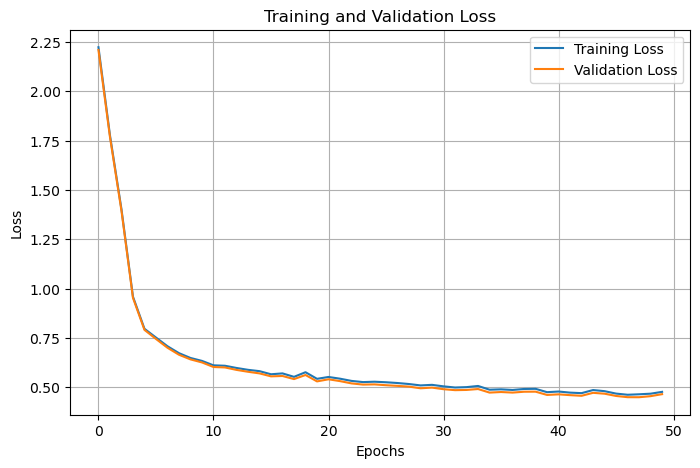

In [19]:
nn = NeuralNetwork(
    input_size=784,
    hidden_sizes=[128, 64],
    output_size=10,
    activations=["relu", "relu", "sigmoid"],
    dropout_rate=0.2
)
# Train the model
train_losses, val_losses = nn.train(
    X_train, y_train_onehot, X_val, y_val_onehot,
    epochs=50, batch_size=64, learning_rate=0.01
)

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


